# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [46]:
import cv2
import os
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np

# plots setup
import matplotlib.pyplot as plt
plt_interval = 50

root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
# if not exist, download mnist dataset
trans = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5,), (1.0,))])
trainset = dset.MNIST(root=root, train=True, transform=trans, download=True)
testset = dset.MNIST(root=root, train=False, transform=trans, download=True)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('0', 'high', 'low')

# create binary dataset 
label1 = [0,1,2,3,4]; label2 = [5,6,7,8,9] # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
# mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
# trainset.train_data=torch.from_numpy(trainset.train_data.numpy()[mask])
# trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == 0) | (trainset.train_labels == 1) | (trainset.train_labels == 2) | (trainset.train_labels == 3) | (trainset.train_labels == 4)
mask2 = (trainset.train_labels == 5) | (trainset.train_labels == 6) | (trainset.train_labels == 7) | (trainset.train_labels == 8) | (trainset.train_labels == 9)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal flip and shuffle new array
# permutation = np.random.permutation(len(trainset.train_labels))
# trainset.train_data = np.concatenate([trainset.train_data, 
#                                       np.flip(trainset.train_data[permutation], axis=2).copy()], 0)
# trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
# mask = (testset.test_labels == label1) | (testset.test_labels == label2)
# testset.test_data=torch.from_numpy(testset.test_data.numpy()[mask])
# testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == 0) | (testset.test_labels == 1) | (testset.test_labels == 2) | (testset.test_labels == 3) | (testset.test_labels == 4)
mask2 = (testset.test_labels == 5) | (testset.test_labels == 6) | (testset.test_labels == 7) | (testset.test_labels == 8) | (testset.test_labels == 9)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("  Dimensions of train images:", np.shape(trainset.train_data))
print("- Test set size:", len(testset))
print("  Dimensions of test images:", np.shape(testset.test_data))

w_size = np.shape(trainset.train_data)[1] * np.shape(trainset.train_data)[2]
print("\nVector dimensionality:", w_size)

Data loaded:
- Training set size: 60000
  Dimensions of train images: torch.Size([60000, 28, 28])
- Test set size: 10000
  Dimensions of test images: torch.Size([10000, 28, 28])

Vector dimensionality: 784


Test Images:


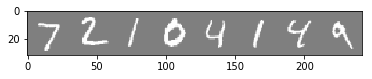

 high   low   low   low   low   low   low  high
Train Images:


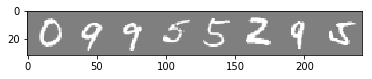

  low  high  high  high  high   low  high  high


In [47]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Weak Learner: Perceptron

In [48]:
# set learning rate
eta = 0.01

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    return weak_learners
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [49]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time), weak_learner

# Online BBM 

In [55]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    gamma = 0.35
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability  
            prob = 1 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                weak_learners = update_WL(weak_learners, x, y, j-1)
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
                
    return n_mistakes_over_time, weak_learners

# AdaBoost OL

In [51]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                weak_learners = update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [52]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        for data in testloader:
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL(weak_learners, x, i)
            correct += (prediction == y).sum()
        print('Accuracy of weak learner', i, 'on the %d test images: %d %%' % (len(testloader), (100 * correct / len(testloader))))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    for data in testloader: 
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg1(weak_learners, x)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the %d test images: %d %%' % (len(testloader), (100 * correct / len(testloader))))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    for data in testloader:
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the %d test images: %d %%' % (len(testloader), (100 * correct / len(testloader))))

## Evaluate Models Online

In [53]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(architecture, T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    weak_learner = np.zeros(w_size)
    mistakes, weak_learner = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, architecture):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(w_size)) 
    
    # test
    mistakes, weak_learners = onlineBBM(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, architecture):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(w_size)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Fraction of mistakes after 5000 iterations: 0.251
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 80 %


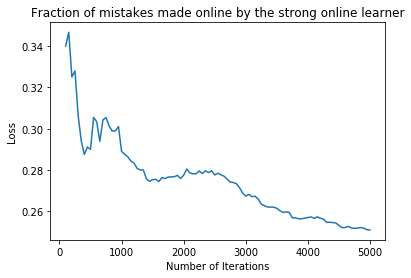

In [21]:
evaluate_baseline(architecture=0, T=5000)

## Online BBM

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.278
Fraction of mistakes by time 2000 0.26
Fraction of mistakes by time 3000 0.256
Fraction of mistakes by time 4000 0.25725
Fraction of mistakes by time 5000 0.2496
Fraction of mistakes after 5000 iterations: 0.2496
Edges of weak learners:
 [0.2504 0.2504 0.2504 0.2504 0.2504]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 10000 test images: 70 %
Accuracy of weak learner 1 on the 10000 test images: 70 %
Accuracy of weak learner 2 on the 10000 test images: 70 %
Accuracy of weak learner 3 on the 10000 test images: 70 %
Accuracy of weak learner 4 on the 10000 test images: 70 %


EVALUATING MODEL
Accuracy of the network on the 10000 test images: 70 %


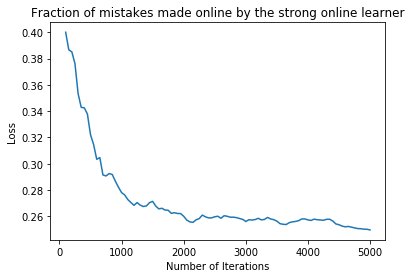

In [56]:
evaluate_onlineBBM(N=5, T=5000, architecture=2)

## Adaboost.OL

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.344
Fraction of mistakes by time 2000 0.2935
Fraction of mistakes by time 3000 0.2783333333333333
Fraction of mistakes by time 4000 0.272
Fraction of mistakes by time 5000 0.2622
Fraction of mistakes after 5000 iterations: 0.2622
Edges of weak learners:
 [0.2328 0.2196 0.202  0.1848 0.1868]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 10000 test images: 79 %
Accuracy of weak learner 1 on the 10000 test images: 73 %
Accuracy of weak learner 2 on the 10000 test images: 63 %
Accuracy of weak learner 3 on the 10000 test images: 76 %
Accuracy of weak learner 4 on the 10000 test images: 56 %


EVALUATING MODEL
Accuracy of the network on the 10000 test images: 79 %


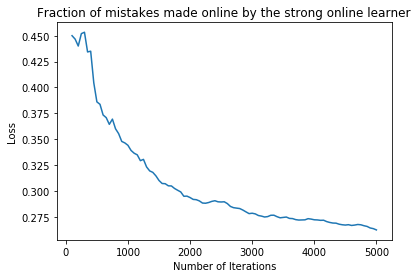

In [45]:
evaluate_adaboostOL(N=5, T=5000, architecture=2)

## Run Experiments

In [21]:
def run_experiment(T=10000, N=10, net=0, model="bbm"):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, net)
    
# ignore net input

In [ ]:
run_experiment(T=20000, N=5, net=0, model="adaboost")

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf